In [1]:
from qibo import Circuit, gates, set_backend
from qiboml.interfaces.keras import QuantumModel
from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation

2025-03-25 11:52:51.318891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742899971.337848   63601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742899971.343545   63601 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Set the backend to qiboml with tensorflow as the platform.
set_backend("qiboml", platform="tensorflow")

# Define the number of qubits
nqubits = 1

# Create the encoding layer
enc = PhaseEncoding(nqubits=nqubits, encoding_gate=gates.RX)

# Trainable layer
def trainable_circuit(entanglement=True):
    trainable_circ  = Circuit(nqubits)
    for q in range(nqubits):
        trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
        trainable_circ.add(gates.RZ(q=q, theta=np.random.randn()))
    if nqubits > 1 and entanglement:
        [trainable_circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]
    return trainable_circ

# Create the decoding layer
dec = Expectation(nqubits=nqubits)

structure = []
for _ in range(3):
    structure.extend([enc, trainable_circuit(entanglement=True)])

# Build the quantum model
model = QuantumModel(
    circuit_structure=structure,
    decoding=dec,
)

# Prepare the training data:
# 30 points evenly spaced between 0 and 2π and their sine values.
x_train = np.linspace(0, 2 * np.pi, 200).reshape(-1, 1)
y_train = np.sin(x_train)
# y_train = 2 * (((y_train - min(y_train)) / (max(y_train) - min(y_train))) - 0.5)

# Compile the model with the Adam optimizer (lr=0.1) and mean squared error loss.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), loss='mse')

# Train the model using the Keras fit interface.
model.fit(x_train, y_train, epochs=5, verbose=1, batch_size=1)

[Qibo 0.2.17|INFO|2025-03-25 12:06:11]: Using qiboml (tensorflow) backend on /device:CPU:0


Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1447
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0004e-05
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1574e-06
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7545e-06
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2586e-06


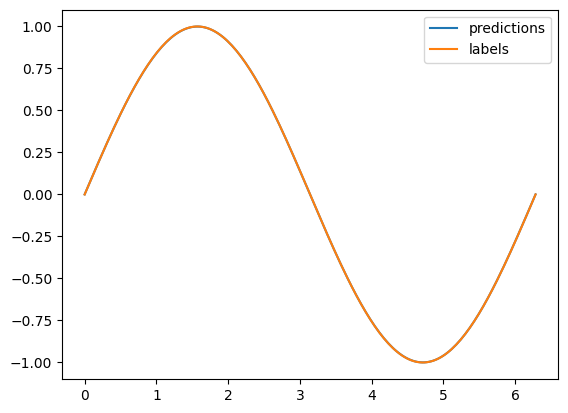

In [27]:
pred = [tf.squeeze(model(x)) for x in x_train]
plt.plot(x_train, pred, label="predictions")
plt.plot(x_train, y_train, label="labels")
plt.legend()

In [28]:
import numpy as np
import tensorflow as tf

# Define the loss function (mean squared error)
loss_fn = tf.keras.losses.MeanSquaredError()

epochs = 5

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_fn(y_train, predictions)
    # Compute gradients
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Print the gradients for each trainable variable
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")
    
    # Apply the gradients
    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

Epoch 1, Loss: 0.4975002408027649
Epoch 2, Loss: 0.49750006198883057
Epoch 3, Loss: 0.4975000023841858
Epoch 4, Loss: 0.49750006198883057
Epoch 5, Loss: 0.49750015139579773


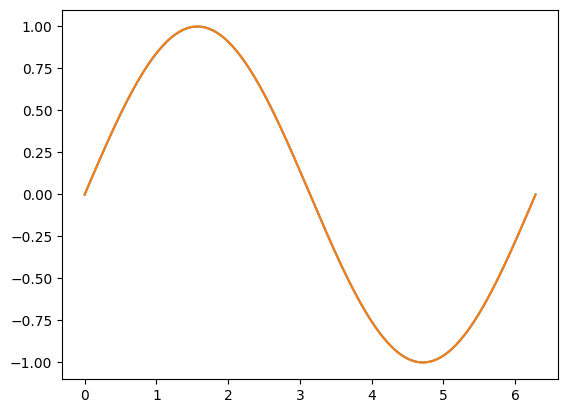

In [29]:
pred = [tf.squeeze(model(x)) for x in x_train]
plt.plot(x_train, pred)
plt.plot(x_train, y_train)